
## Introduction

The aim of this assignment is to give you the experience of using real public data and create your own report. The raw data are available in different formats and structures and often contain undesired formatting errors. Statistical data are continuously updated and may even provide API's to stream data instead of taking snapshots. We will be using snapshots in this assignment but to streamline the analysis around possible future snapshots you'll be implementing a 'data-specific' Python class with appropriate methods for data manipulation and visualisation.

**Note:** please direct your questions on this assignment to **r.monajemi@lumc.nl**

## Data: Emissions to air by the Dutch economy

In this assignment we will be using *Emissions to air by the Dutch economy* [CBS StatLine](https://opendata.cbs.nl/portal.html?_la=en&_catalog=CBS&tableId=83300ENG&_theme=1129) dataset. There you'll find the latest release of the dataset, however and older version will be provided via brightspace. Note that the results that shown below are produced using the old datasets: the metadata (`83300ENG_metadata.csv`) and the raw data (`83300ENG_UntypedDataSet_29032023_184145.csv`). 




## Assignment

#### 1) Class GWP [4p].

- Create the class `GWP` (Global Warming Potential) which is initialised with raw data along with the meta information.
- Create class attributes [emissions](emissions.md) and [emission_sources](emission_sources.md) from the metadata.
- Additional attributes:
    - `Date` :  of type timestamp created from the variable `Periods`
    - `Source` : holding the `Title` values of the emission source in the metadata.

In [2]:
#### Exercise 1 ####

import pandas as pd

class GWP:
    def __init__(self, meta_path, path):
        self.meta_path = meta_path
        self.path = path
        self.metadata_dfs = {}
        self.load_metadata()
        self.parse_metadata()
        self.parse_data()
    
    def load_metadata(self):
        metadata_sections = {
            'TableInfos': list(range(1, 3)), 
            'DataProperties': list(range(4, 26)), 
            'DutchEconomy': list(range(27, 87)), 
            'Periods': list(range(88, 121))
        }

        for section, lines in metadata_sections.items():
            read_df = pd.read_csv(
                self.meta_path,
                delimiter=";",
                skiprows=lambda x: x not in lines
            )
            self.metadata_dfs[section] = read_df

    def parse_metadata(self):
        self.emissions = self.metadata_dfs['DataProperties'][['Title','Description', 'Unit']].dropna()
        self.emission_sources = self.metadata_dfs['DutchEconomy']
        self.emission_sources = self.emission_sources.rename(columns = {'Key': 'DutchEconomy'})
        self.Date = pd.to_datetime(self.metadata_dfs['Periods']['Key'].str[:4] + '-01-01')
        self.Source = self.emission_sources['Title']

        

    def parse_data(self):
        self.data = pd.read_csv(self.path, delimiter = ';')
        self.data['Date'] = pd.to_datetime(self.data['Periods'].str[:4] + '-01-01')

        # add Title (source) and description to data

        selected_columns = self.emission_sources[['DutchEconomy', 'Title', 'Description']]
        self.data = self.data.merge(selected_columns, on='DutchEconomy', how='left')
        self.data = self.data.rename(columns = {'Title': 'Source'})
        

  
gwp = GWP(meta_path='data/83300ENG_metadata.csv', path = 'data/83300ENG_UntypedDataSet_29032023_184145.csv')

gwp.emissions.head()
#gwp.emission_sources.head()
#gwp.Source
#gwp.Date
#gwp.data.head()





,Title,Description,Unit
4,Total CO2,Carbon dioxide.\nGreenhouse gas (causes the te...,mln kgs
5,CO2 excl. biomass,Carbon dioxide.excluding emissions from biomas...,mln kgs
6,CO2 biomass,Carbon dioxide.emissions from biomass.\nGreenh...,mln kgs
7,N2O,Laughing gas/dinitrogen oxide.\nN2O is formed ...,mln kgs
8,CH4,Methane (= natural gas).\nAmong other causes C...,mln kgs


In [31]:
gwp = GWP(path="data/83300ENG_UntypedDataSet_29032023_184145.csv", meta_path='data/83300ENG_metadata.csv')

In [32]:
gwp.emissions.head()

,Title,Description,Unit
4,Total CO2,Carbon dioxide.\nGreenhouse gas (causes the te...,mln kgs
5,CO2 excl. biomass,Carbon dioxide.excluding emissions from biomas...,mln kgs
6,CO2 biomass,Carbon dioxide.emissions from biomass.\nGreenh...,mln kgs
7,N2O,Laughing gas/dinitrogen oxide.\nN2O is formed ...,mln kgs
8,CH4,Methane (= natural gas).\nAmong other causes C...,mln kgs


In [33]:
gwp.emission_sources.head()

,DutchEconomy,Title,Description
0,1050010,Total private households,Private households:\nA private household gathe...
1,B000579,Total Dutch economy,"This includes emissions from households, from ..."
2,B000580,Transport activity by private households,Air emissions caused by transportation activit...
3,B000581,Other private households,Emissions to air caused by other activities of...
4,T001081,A-U All economic activities,All economic activities


In [34]:
gwp.data.dtypes

ID                                      int64
DutchEconomy                           object
Periods                                object
TotalCO2_1                              int64
CO2ExclBiomass_2                        int64
CO2Biomass_3                          float64
N2O_4                                 float64
CH4_5                                 float64
GreenhouseGasEquivalents_6              int64
NOx_7                                 float64
SO2_8                                 float64
NH3_9                                 float64
AcidificationEquivalents_10           float64
CFK12Equivalents_11                   float64
CO_12                                 float64
NMVOC_13                              float64
PM10_14                               float64
Date                           datetime64[ns]
Source                                 object
Description                            object
dtype: object

#### 2) Greenhouse equivalents [1p].

The [greenhouse equivalents](https://www.cbs.nl/en-gb/news/2020/19/uitstoot-broeikasgassen-3-procent-lager-in-2019/co2-equivalents) is a measure to relate othe other gases to CO2.

- Convert `N2O_4` and `CH4_5` in `GWP.data` to CO2 equivalents.
- Add a new variable `HFC` to the GWP.data which contains the fluorine (chlorine) gases CO2 equivalents. HFC stands for hydrofluorocarbons (see [Fluorinated gases](https://en.wikipedia.org/wiki/Fluorinated_gases)). The emission has been added to the total greenhouse gas equivalent but not specified as separate variable. See also *greenhouse gas equivalents* description in the metadata.

In [35]:
gwp.data

,ID,DutchEconomy,Periods,TotalCO2_1,CO2ExclBiomass_2,CO2Biomass_3,N2O_4,CH4_5,GreenhouseGasEquivalents_6,NOx_7,SO2_8,NH3_9,AcidificationEquivalents_10,CFK12Equivalents_11,CO_12,NMVOC_13,PM10_14,Date,Source,Description
0,0,B000579,1990JJ00,179680,173604,6075.4,58.9,1274.0,238279,786.8,255.5,344.6,45.3,6194.4,1194.1,622.0,84.9,1990-01-01,Total Dutch economy,"This includes emissions from households, from ..."
1,1,B000579,1991JJ00,188714,182485,6228.9,59.6,1290.0,247756,769.8,220.2,349.1,44.1,5109.8,1160.9,575.3,80.9,1991-01-01,Total Dutch economy,"This includes emissions from households, from ..."
2,2,B000579,1992JJ00,189299,183070,6228.6,60.5,1274.0,249169,769.9,219.3,291.2,40.7,4025.2,1154.0,542.6,77.8,1992-01-01,Total Dutch economy,"This includes emissions from households, from ..."
3,3,B000579,1993JJ00,190159,183679,6479.8,61.5,1256.0,250502,755.5,213.9,305.4,41.0,2940.6,1103.8,510.2,73.9,1993-01-01,Total Dutch economy,"This includes emissions from households, from ..."
4,4,B000579,1994JJ00,192668,186276,6391.9,60.0,1214.9,253263,734.5,204.7,273.0,38.4,1856.0,1030.6,479.2,70.4,1994-01-01,Total Dutch economy,"This includes emissions from households, from ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1883,1883,A045808,2017JJ00,456,0,456.5,0.0,102.8,3336,0.1,0.0,0.0,0.0,9.3,1.0,0.5,0.0,2017-01-01,Landfill sites (waste dumps),Locations where waste is dumped.
1884,1884,A045808,2018JJ00,429,0,428.6,0.0,88.5,2907,0.1,0.0,0.0,0.0,9.2,0.9,0.4,0.0,2018-01-01,Landfill sites (waste dumps),Locations where waste is dumped.
1885,1885,A045808,2019JJ00,404,0,404.5,0.0,94.9,3062,0.1,0.0,0.0,0.0,8.8,0.9,0.4,0.0,2019-01-01,Landfill sites (waste dumps),Locations where waste is dumped.
1886,1886,A045808,2020JJ00,386,0,385.8,0.0,88.5,2865,0.1,0.0,0.0,0.0,8.2,1.0,0.4,0.0,2020-01-01,Landfill sites (waste dumps),Locations where waste is dumped.


In [3]:
#### Exercise 2 ####

# Convert to greenhouse equivalents (GE)
gwp.data['N2O_4'] = gwp.data['N2O_4'] * 298
gwp.data['CH4_5'] = gwp.data['CH4_5'] * 25


#Total CO2 equivalents
total_GE = gwp.data['TotalCO2_1'] + gwp.data['N2O_4'] + gwp.data['CH4_5']

#add hydrofluorocarbons
gwp.data['HFC'] = total_GE - gwp.data['GreenhouseGasEquivalents_6']



gwp.data

,ID,DutchEconomy,Periods,TotalCO2_1,CO2ExclBiomass_2,CO2Biomass_3,N2O_4,CH4_5,GreenhouseGasEquivalents_6,NOx_7,...,NH3_9,AcidificationEquivalents_10,CFK12Equivalents_11,CO_12,NMVOC_13,PM10_14,Date,Source,Description,HFC
0,0,B000579,1990JJ00,179680,173604,6075.4,17552.2,31850.0,238279,786.8,...,344.6,45.3,6194.4,1194.1,622.0,84.9,1990-01-01,Total Dutch economy,"This includes emissions from households, from ...",-9196.8
1,1,B000579,1991JJ00,188714,182485,6228.9,17760.8,32250.0,247756,769.8,...,349.1,44.1,5109.8,1160.9,575.3,80.9,1991-01-01,Total Dutch economy,"This includes emissions from households, from ...",-9031.2
2,2,B000579,1992JJ00,189299,183070,6228.6,18029.0,31850.0,249169,769.9,...,291.2,40.7,4025.2,1154.0,542.6,77.8,1992-01-01,Total Dutch economy,"This includes emissions from households, from ...",-9991.0
3,3,B000579,1993JJ00,190159,183679,6479.8,18327.0,31400.0,250502,755.5,...,305.4,41.0,2940.6,1103.8,510.2,73.9,1993-01-01,Total Dutch economy,"This includes emissions from households, from ...",-10616.0
4,4,B000579,1994JJ00,192668,186276,6391.9,17880.0,30372.5,253263,734.5,...,273.0,38.4,1856.0,1030.6,479.2,70.4,1994-01-01,Total Dutch economy,"This includes emissions from households, from ...",-12342.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1883,1883,A045808,2017JJ00,456,0,456.5,0.0,2570.0,3336,0.1,...,0.0,0.0,9.3,1.0,0.5,0.0,2017-01-01,Landfill sites (waste dumps),Locations where waste is dumped.,-310.0
1884,1884,A045808,2018JJ00,429,0,428.6,0.0,2212.5,2907,0.1,...,0.0,0.0,9.2,0.9,0.4,0.0,2018-01-01,Landfill sites (waste dumps),Locations where waste is dumped.,-265.5
1885,1885,A045808,2019JJ00,404,0,404.5,0.0,2372.5,3062,0.1,...,0.0,0.0,8.8,0.9,0.4,0.0,2019-01-01,Landfill sites (waste dumps),Locations where waste is dumped.,-285.5
1886,1886,A045808,2020JJ00,386,0,385.8,0.0,2212.5,2865,0.1,...,0.0,0.0,8.2,1.0,0.4,0.0,2020-01-01,Landfill sites (waste dumps),Locations where waste is dumped.,-266.5


In [37]:
gwp.emissions

,Title,Description,Unit
4,Total CO2,Carbon dioxide.\nGreenhouse gas (causes the te...,mln kgs
5,CO2 excl. biomass,Carbon dioxide.excluding emissions from biomas...,mln kgs
6,CO2 biomass,Carbon dioxide.emissions from biomass.\nGreenh...,mln kgs
7,N2O,Laughing gas/dinitrogen oxide.\nN2O is formed ...,mln kgs
8,CH4,Methane (= natural gas).\nAmong other causes C...,mln kgs
9,Greenhouse gas equivalents,A measure of the degree to which a substance c...,x mln
11,NOx,"Nitrogen oxides (NOx = NO and NO2, calculated ...",mln kgs
12,SO2,"Sulphur dioxide (SO2 and SO3, calculated as SO...",mln kgs
13,NH3,Ammonia (NH3).\nNH3 is formed in particular du...,mln kgs
14,Acidification equivalents,A measure of the degree to which a substance c...,mld acid-equivalents


In [38]:
gwp.Source

0                     Total private households
1                          Total Dutch economy
2     Transport activity by private households
3                     Other private households
4                  A-U All economic activities
5          A Agriculture, forestry and fishing
6       B-E Industry (no construction), energy
7                       B Mining and quarrying
8                              C Manufacturing
9      10-12 Manufacture of food and beverages
10     13-15 Man. of textile-, leatherproducts
11     16-18 Man. wood en paperprod., printing
12             16 Manufacture of wood products
13                     17 Manufacture of paper
14                18 Printing and reproduction
15        19 Manufacture of coke and petroleum
16         20-21 Chemistry and pharmaceuticals
17                 20 Manufacture of chemicals
18           21 Manufacture of pharmaceuticals
19    22-23 Man. plastics and constructionprod
20     22 Manufacture rubber, plastic products
21        23 

#### 3) Implement a plot method that produces the figure below. [3p]

**Synopsis:** &nbsp; &nbsp;**<tt>GWP.plot(emission, source)</tt>**

    - emission: is a list of emissions to be drawn
    - source: list of Dutch economy sector id's or a pattern

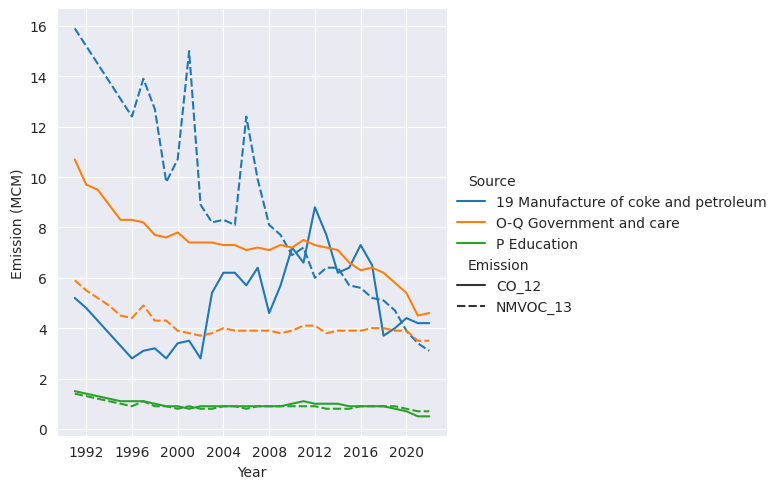

In [9]:
gwp.plot(emission=['CO_12', 'NMVOC_13'],source=['education', 'government','320000' ]);

Palette colors: [(0.12156862745098039, 0.4666666666666667, 0.7058823529411765), (1.0, 0.4980392156862745, 0.054901960784313725)]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/seaborn/_core.py:1225: FutureWarning: is_categoric

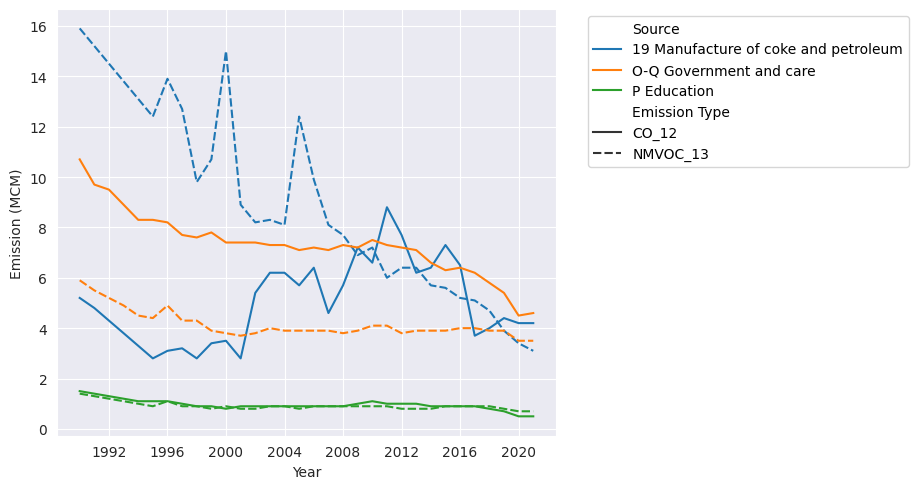

In [4]:
#### Exercise 3 ####

import matplotlib.pyplot as plt
import seaborn as sb
import re


def plot(self, emission=['CO_12', 'NMVOC_13'],source=['education', 'government','320000' ]):

    # Creating the plot
    f = plt.figure(figsize=(12, 5))
    gs = f.add_gridspec(1, 1)

    with sb.axes_style("darkgrid"):
        ax = f.add_subplot(gs[0, 0])

    f.tight_layout()


 

    # pattern search for user-specific entries
    sources = set()
    economies = set()

    for idx, row in gwp.data.iterrows():
        for s in source:
            
            match_s = re.search(s, row['Description'], flags=re.IGNORECASE)
            match_e = re.search(s, row['DutchEconomy'], flags=re.IGNORECASE)

            if match_s:
                sources.add(row['Source'])

            elif match_e:
                economies.add(row['DutchEconomy'])

    # Create boolean masks
    source_mask = gwp.data['Source'].isin(sources)
    economy_mask = gwp.data['DutchEconomy'].isin(economies)

    # Combine masks using a logical OR
    combined_mask = source_mask | economy_mask

    # Filter the DataFrame
    filtered_df = gwp.data[combined_mask]

    # Melt the DataFrame
    df_melted = pd.melt(filtered_df, id_vars=['Date', 'Source'], value_vars = emission, 
                    var_name='Emission Type', value_name='Emission Value')

    # Define and print the palette
    palette = sb.color_palette(n_colors= len(sources))
    print("Palette colors:", palette)


    # Plotting for each source with different styles
    sb.lineplot(data=df_melted, x='Date', y='Emission Value', hue='Source', style='Emission Type', dashes=True)


    # Adding title and labels
    plt.xlabel('Year')
    plt.ylabel('Emission (MCM)')


    # Adding the legend outside the plot area, right next to it
    plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))


    # Adjust layout to make room for the legend outside the plot
    plt.tight_layout(rect=[0, 0, 0.8, 1])

    # Show the plot
    plt.show()


# attach the plotting method to the class
GWP.plot = plot

gwp.plot(emission=['CO_12', 'NMVOC_13'],source=['education', 'government','320000' ])


#### 4) Emission categories [1p]

There are 4 categories of emissions:
   - Greenhouse gases (climate change) {TotalCO2_1, CO2ExclBiomass_2, CO2Biomass_3, N2O_4, CH4_5, GreenhouseGasEquivalents_6}
   - Acidification {NOx_7, SO2_8, NH3_9, AcidificationEquivalents_10}
   - Ozone layer depletion {CFK12Equivalents_11}
   - Other air pollution {CO_12, NMVOC_13, PM10_14, HFC}

Implement the method `get_emission` with the following specification:

**Synopsis:** &nbsp; &nbsp;**<tt>GWP.get_emission(emission_category)</tt>**

   - emission_category : {ghg, acid, ozone, air}
   - return value : list of variable names of the given category.


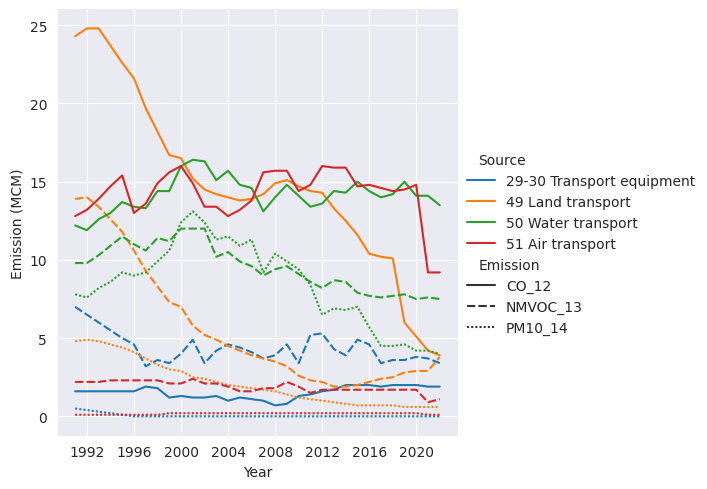

In [10]:
gwp.plot(emission=gwp.get_emission('CO_12'),source=['transport']);

Palette colors: [(0.12156862745098039, 0.4666666666666667, 0.7058823529411765), (1.0, 0.4980392156862745, 0.054901960784313725), (0.17254901960784313, 0.6274509803921569, 0.17254901960784313), (0.8392156862745098, 0.15294117647058825, 0.1568627450980392), (0.5803921568627451, 0.403921568627451, 0.7411764705882353), (0.5490196078431373, 0.33725490196078434, 0.29411764705882354), (0.8901960784313725, 0.4666666666666667, 0.7607843137254902), (0.4980392156862745, 0.4980392156862745, 0.4980392156862745)]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/seaborn/_core.py:1225: FutureWarning: is_categoric

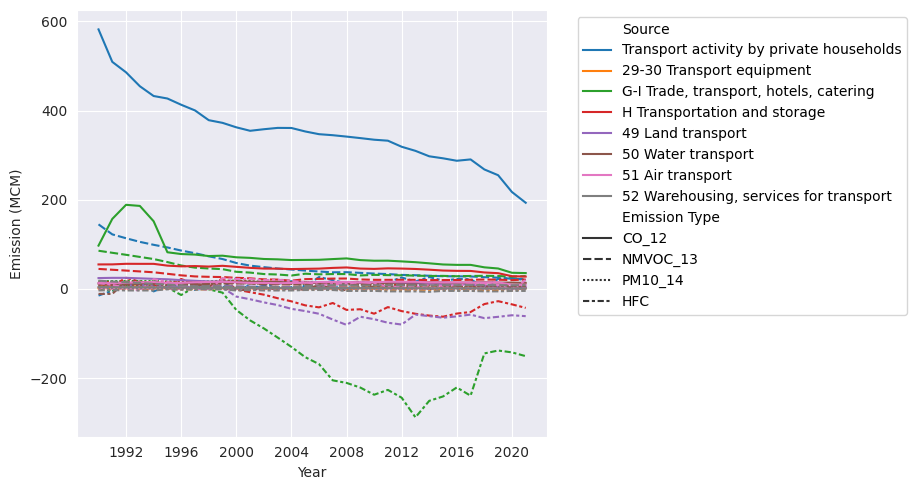

In [43]:
#### Exercise 4 ####

def get_emission(self, emission_category):

    # define dictionary for emission categories
    emissions = {
        "ghg": [
            "TotalCO2_1", 
            "CO2ExclBiomass_2", 
            "CO2Biomass_3", 
            "N2O_4", 
            "CH4_5", 
            "GreenhouseGasEquivalents_6"
        ],
        "acid": [
            "NOx_7", 
            "SO2_8", 
            "NH3_9", 
            "AcidificationEquivalents_10"
        ],
        "ozone": [
            "CFK12Equivalents_11"
        ],
        "air": [
            "CO_12", 
            "NMVOC_13", 
            "PM10_14", 
            "HFC"
        ]
    }

    return emissions[emission_category]

GWP.get_emission = get_emission

gwp.plot(emission=gwp.get_emission('air'),source=['transport'])


#### 5) Summary [1p]

Implement the `summary` method which gives `general information` about the data such as:
- data and meta file paths
- shape of the data
- number of emission sources.
- number of emission variables
- first and latest date


**Synopsis:** &nbsp; &nbsp;**<tt>GWP.summary(date)</tt>**
   - `date`     : tuple of dates (min,[max]).

If `date` is given then print a DataFrame of descriptive statistics with columns {min, 1st quartile, 2nd quartile, mean 3rd quartile, max} and emission as row indices. In this case do not output the `general information`. Note, for the `date` method argument, in case 'max' is omitted then the summary is given for a single year.


In [85]:
#### Exercise 5 ####

def summary(self, date = None):
    if date is None:
            # General information
            print(f"Data file path: {self.path}")
            print(f"Meta file path: {self.meta_path}")
            print(f"Shape of the data: {self.data.shape}")
            print(f"Number of emission sources: {self.emission_sources.shape[0]}")
            print(f"Number of emission variables: {self.emissions.shape[0]}")
            print(f"First date: {self.data['Date'].min()}")
            print(f"Latest date: {self.data['Date'].max()}")
    else:
        
        # date- specific summary
        min_date, max_date = date if len(date) == 2 else (pd.to_datetime(date[0]), pd.to_datetime(date[0]))

        # filter data frame according to date range
        df_filtered = self.data[(self.data['Date'] >= min_date) & (self.data['Date'] <= max_date)]
        
        # drop unnecessary elements
        df_filtered = df_filtered.drop(columns = ['ID', 'DutchEconomy', 'Periods', 'Source', 'Description'])

        # Reshape the data for statistical analysis
        melted_data = df_filtered.melt(id_vars=['Date'], var_name='EmissionType', value_name='Emission')

        # Compute descriptive statistics for each emission type
        stats = melted_data.groupby('EmissionType')['Emission'].describe()

        # drop unnecessary elements
        stats = stats.drop(columns = ['count', 'std'])

        print(stats)

        # return data frame with summary statistics
        return(stats)

GWP.summary = summary

df_summary = gwp.summary(("1991-01-01",))


                                     mean     min     25%     50%      75%  \
EmissionType                                                                 
AcidificationEquivalents_10      2.796610     0.0    0.00     0.2     1.35   
CFK12Equivalents_11            422.718644     0.0    8.40    43.3   258.60   
CH4_5                         1468.474576     0.0    2.50     7.5    61.25   
CO2Biomass_3                   348.798305     0.0    0.05     1.6    29.20   
CO2ExclBiomass_2             13297.627119     0.0  417.00  1662.0  7853.50   
CO_12                           77.961017     0.0    1.35     5.7    31.40   
GreenhouseGasEquivalents_6   17141.728814     0.0  562.00  2514.0  9957.00   
HFC                           -750.413559 -9031.2  -54.55    -4.0    -0.75   
N2O_4                         1276.349153     0.0    0.00     0.0    74.50   
NH3_9                           18.005085     0.0    0.00     0.0     0.25   
NMVOC_13                        38.789831     0.0    1.50     5.

#### 6) Bonus point

Add a new plot method to the class which gives a different kind of information than the one given in GWP.plot.